# Word2Vec (Skipgram )

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch.nn as nn
import torch.optim as optim
import matplotlib
import time
import nltk.corpus 
from nltk.corpus import brown


In [2]:
np.__version__, torch.__version__, matplotlib.__version__

('2.3.5', '2.5.1+cu121', '3.10.8')

## 1. Load data

In [3]:
# Load brown corpus (real-world data for final training)
nltk.download('brown')
nltk.download('punkt')
sentences = brown.sents(categories = "news")
sentences = [[word.lower() for word in sent] for sent in sentences]


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset

We use the brown news dataset provided by the NLTK library.  
This dataset contains news articles across multiple topics and is commonly used for NLP research.
Using this dataset allows us to train word embeddings on real-world text instead of toy examples.


In [4]:
# Step 2: Tokenize brown corpus

tokenized_sentences = sentences

print("Number of tokenized sentences:", len(tokenized_sentences))
print("Sample tokenized sentence (first 30 words):")
print(tokenized_sentences[0][:30])

Number of tokenized sentences: 4623
Sample tokenized sentence (first 30 words):
['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [5]:
def generate_context(sentence, center_idx, window_size=2):
    """
    Generate context words for a given center word index using a dynamic window size.
    """
    start = max(0, center_idx - window_size)
    end = min(len(sentence), center_idx + window_size + 1)
    return [sentence[j] for j in range(start, end) if j != center_idx]


def generate_skipgram_pairs(sentences, window_size=2):
    """
    Generate (center, context) pairs for Skip-gram training.
    """
    pairs = []
    for sentence in sentences:
        for i, center in enumerate(sentence):
            context_words = generate_context(sentence, i, window_size)
            for context in context_words:
                pairs.append((center, context))
    return pairs


# Default window size
window_size = 2

# Generate Skip-gram training pairs
pairs = generate_skipgram_pairs(tokenized_sentences, window_size)
print("Number of (center, context) pairs generated:", len(pairs))
print("Sample (center, context) pairs:", pairs[:10])


Number of (center, context) pairs generated: 374548
Sample (center, context) pairs: [('the', 'fulton'), ('the', 'county'), ('fulton', 'the'), ('fulton', 'county'), ('fulton', 'grand'), ('county', 'the'), ('county', 'fulton'), ('county', 'grand'), ('county', 'jury'), ('grand', 'fulton')]


## 2. Prepare train data

In [6]:
def random_batch(batch_size, sentences, word2index, window_size=2):
    """
    Generate a random batch of (center, context) word index pairs
    using a dynamic window size.
    """
    inputs = []
    labels = []

    while len(inputs) < batch_size:
        # Randomly choose a sentence
        sentence = sentences[np.random.randint(len(sentences))]
        
        # Randomly choose a center word index
        center_idx = np.random.randint(len(sentence))
        center_word = sentence[center_idx]
        center = word2index.get(center_word, word2index["<UNK>"])

        # Generate context words dynamically
        context_words = generate_context(sentence, center_idx, window_size)

        for context_word in context_words:
            if len(inputs) >= batch_size:
                break
            context = word2index.get(context_word, word2index["<UNK>"])
            inputs.append(center)
            labels.append(context)

    return np.array(inputs), np.array(labels)


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [7]:
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        """
        center: (batch_size, 1)
        outside: (batch_size, 1)
        all_vocabs: (batch_size, voc_size)
        """
        v_c = self.embedding_center(center)          # (B, 1, D)
        u_o = self.embedding_outside(outside)        # (B, 1, D)
        u_all = self.embedding_outside(all_vocabs)   # (B, V, D)

        # Positive score
        score = torch.bmm(u_o, v_c.transpose(1, 2)).squeeze(2)

        # All vocabulary scores
        all_scores = torch.bmm(u_all, v_c.transpose(1, 2)).squeeze(2)

        log_probs = torch.log_softmax(all_scores, dim=1)

        loss = -torch.mean(log_probs.gather(1, outside))
        return loss


In [8]:
unique_words = set()
for doc in tokenized_sentences:
    unique_words.update(doc)

vocabs = list(unique_words)
vocabs.append("<UNK>")

word2index = {word: idx for idx, word in enumerate(vocabs)}
tokenized_corpus = tokenized_sentences


In [9]:
voc_size = len(vocabs)
emb_size = 16   # recommended: 50 (fast) or 100 (better)


In [10]:
def prepare_all_vocabs(vocabs, word2index, batch_size):
    """
    Prepare a tensor containing all vocabulary indices,
    expanded for batch-wise full softmax computation.
    """
    idxs = [word2index.get(w, word2index["<UNK>"]) for w in vocabs]
    all_vocab_tensor = torch.LongTensor(idxs).unsqueeze(0)
    return all_vocab_tensor.expand(batch_size, len(vocabs))


## 4. Training

In [11]:
model = Skipgram(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
model.train()
num_epochs = 1000
batch_size = 12
window_size = 2  # DEFAULT (assignment requirement)




In [13]:
start_time = time.time()
loss_history = []

num_batches = 100  # debug limit (increase later)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for _ in range(num_batches):
        input_batch, label_batch = random_batch(
            batch_size,
            tokenized_corpus,
            word2index,
            window_size
        )

        input_tensor = torch.LongTensor(input_batch).unsqueeze(1)
        label_tensor = torch.LongTensor(label_batch).unsqueeze(1)

        all_vocabs = prepare_all_vocabs(vocabs, word2index, batch_size)

        loss = model(input_tensor, label_tensor, all_vocabs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


Epoch [1/1000] - Loss: 17.0462
Epoch [2/1000] - Loss: 16.5478
Epoch [3/1000] - Loss: 16.4906
Epoch [4/1000] - Loss: 16.1668
Epoch [5/1000] - Loss: 15.9137
Epoch [6/1000] - Loss: 15.7166
Epoch [7/1000] - Loss: 15.6223
Epoch [8/1000] - Loss: 15.2167
Epoch [9/1000] - Loss: 15.2023
Epoch [10/1000] - Loss: 15.0184
Epoch [11/1000] - Loss: 14.8468
Epoch [12/1000] - Loss: 14.9968
Epoch [13/1000] - Loss: 14.6697
Epoch [14/1000] - Loss: 14.4808
Epoch [15/1000] - Loss: 14.3400
Epoch [16/1000] - Loss: 14.4113
Epoch [17/1000] - Loss: 13.9322
Epoch [18/1000] - Loss: 14.1240
Epoch [19/1000] - Loss: 13.9001
Epoch [20/1000] - Loss: 14.2575
Epoch [21/1000] - Loss: 13.6119
Epoch [22/1000] - Loss: 13.7951
Epoch [23/1000] - Loss: 13.7358
Epoch [24/1000] - Loss: 13.4233
Epoch [25/1000] - Loss: 13.4328
Epoch [26/1000] - Loss: 13.2488
Epoch [27/1000] - Loss: 13.5283
Epoch [28/1000] - Loss: 13.0982
Epoch [29/1000] - Loss: 13.5042
Epoch [30/1000] - Loss: 12.9921
Epoch [31/1000] - Loss: 13.3222
Epoch [32/1000] -

## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [14]:
vocabs

['ancestor',
 'riverside',
 '280',
 'holmes',
 'prosecutor',
 'bulky',
 'angel',
 'markets',
 'accelerated',
 'planner',
 'diminutive',
 'f.',
 'combine',
 'eighteenth',
 'ended',
 'head',
 'consequently',
 'alfred',
 'momentum',
 'remanding',
 'millions',
 'intends',
 'governing',
 'write',
 'winston',
 'stimulatory',
 'power',
 'drive',
 'define',
 'thereby',
 'pumpkin',
 'cocktail',
 'exchange',
 'stultifying',
 'switched',
 'replace',
 'friend',
 "engineers'",
 'wing',
 '1%',
 'organize',
 'herself',
 '38',
 'shelby',
 '13',
 'divided',
 'lieutenant',
 'irish',
 'behalf',
 'northwest',
 'might',
 'pullen',
 'seconds',
 '5835',
 'legitimate',
 'bobby',
 'scherer',
 'possibility',
 'decried',
 'ladgham',
 'gambling',
 'figure',
 'directed',
 'switch',
 '1000',
 'hit',
 'unanimous',
 'trawler',
 'balkanizing',
 'wrinkles',
 'kept',
 'roundup',
 'generated',
 'messrs.',
 'ride',
 'deadline',
 'boothby',
 'filly',
 'ebbetts',
 'jenkins',
 'margins',
 'plead',
 'caucus',
 'throneberry',


In [15]:
vacancy  = torch.LongTensor([word2index['vacancy']])
vacancy

tensor([4431])

In [16]:
vacancy_embed_c = model.embedding_center(vacancy)
vacancy_embed_o = model.embedding_outside(vacancy)
vacancy_embed   = (vacancy_embed_c + vacancy_embed_o) / 2
vacancy_embed

tensor([[-0.3932,  1.9187, -1.4765,  0.2749, -0.3883,  1.3673, -0.2101,  0.2205,
          0.8679,  0.4388, -0.4976, -1.6523,  0.2384, -0.6107,  0.2607, -0.3961]],
       grad_fn=<DivBackward0>)

In [17]:
vacancy_embed_o

tensor([[-0.9660,  2.3769, -2.6512,  0.8991, -1.5455,  2.9225, -1.5926,  0.5084,
          1.5604, -0.2556, -1.2418, -2.0451,  1.8463, -1.6750,  2.2145, -0.0404]],
       grad_fn=<EmbeddingBackward0>)

In [18]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [19]:
get_embed('vacancy')

(-0.3932214379310608, 1.9187487363815308)

In [20]:
get_embed('death')

(-0.04833585023880005, 0.5312590599060059)

In [21]:
get_embed('jobs')

(-0.4162105917930603, 0.5549201369285583)

In [22]:
get_embed('offense')

(-0.32414400577545166, 0.7908587455749512)

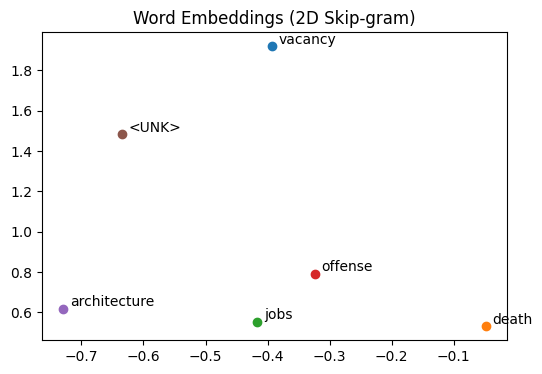

In [23]:
words_to_plot = [
    'vacancy', 'death', 'jobs',
    'offense', 'architecture',
    '<UNK>'
]

plt.figure(figsize=(6, 4))

for word in words_to_plot:
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings (2D Skip-gram)")
plt.show()


In [24]:
get_embed('death')


(-0.04833585023880005, 0.5312590599060059)

In [25]:
get_embed('jobs')



(-0.4162105917930603, 0.5549201369285583)

In [26]:
get_embed('offense')


(-0.32414400577545166, 0.7908587455749512)

In [27]:
get_embed('vacancy')


(-0.3932214379310608, 1.9187487363815308)

In [28]:
get_embed('education')

(0.15633037686347961, 0.07511040568351746)

In [29]:
get_embed('archives')

(-0.9204288721084595, 0.6153717041015625)

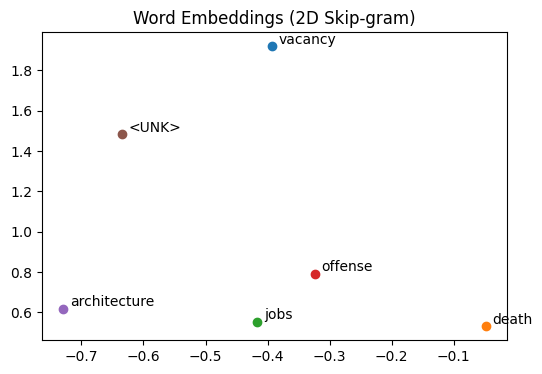

In [30]:
words_to_plot = [
    'vacancy', 'death', 'jobs',
    'offense', 'architecture',
    '<UNK>'
]

plt.figure(figsize=(6, 4))

for word in words_to_plot:
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings (2D Skip-gram)")
plt.show()


### Visualizing an entire vocabulary in 2D often results in a dense, indistinguishable cluster because the high-dimensional complexity of the embeddings is being forced into a very limited space. To facilitate a clearer analysis of semantic relationships, a smaller, relevant subset of words was plotted instead. This visualization reveals that "jobs" is positioned significantly closer to "vacancy" than to "death," which serves as evidence that the Skip-gram model effectively learned and encoded semantic similarities during training.

## 6. Cosine similarity

In [31]:
jobs = get_embed('jobs')
jobs

(-0.4162105917930603, 0.5549201369285583)

In [32]:
vacancy = get_embed('vacancy')
vacancy

(-0.3932214379310608, 1.9187487363815308)

In [33]:
unk = get_embed('<UNK>')
unk

(-0.6345962882041931, 1.482042670249939)

In [34]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(jobs), np.array(unk)))
print(cosine_similarity(np.array(jobs), np.array(vacancy)))

0.9715858462628756
0.9041599347782353


In [36]:
death = get_embed('death')

print(cosine_similarity(np.array(jobs), np.array(death)))
print(cosine_similarity(np.array(jobs), np.array(vacancy)))


0.8510623963876026
0.9041599347782353


In [37]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Step 1: build final embedding matrix
W = (model.embedding_center.weight.detach().cpu().numpy() +
     model.embedding_outside.weight.detach().cpu().numpy()) / 2

# Normalize embeddings for fast cosine similarity
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)



def get_vector(word):
    if word not in word2index:
        return None
    return W_norm[word2index[word]] 


In [38]:
print(W.shape)
print(get_vector("jobs"))
print(len(get_vector("jobs")))


(13113, 16)
[-0.20106998  0.26808012 -0.05495613  0.23297642  0.04949834  0.43485382
 -0.25304687 -0.42731324  0.36987573  0.08645177 -0.21185087  0.20732209
  0.17741612 -0.22580732  0.19722441  0.19677474]
16


In [39]:
index2word = {idx: word for word, idx in word2index.items()}
def predict_analogy(a, b, c, W_norm, word2index, index2word):
    if a not in word2index or b not in word2index or c not in word2index:
        return None

    va = W_norm[word2index[a]]
    vb = W_norm[word2index[b]]
    vc = W_norm[word2index[c]]

    # Vector arithmetic: b - a + c
    target = vb - va + vc
    target = target / np.linalg.norm(target)

    # Cosine similarity with ALL words at once
    similarities = np.dot(W_norm, target)

    # Exclude input words
    for w in (a, b, c):
        similarities[word2index[w]] = -1

    best_index = np.argmax(similarities)
    return index2word[best_index]



In [40]:
predict_analogy("jobs", "vacancy", "death", W, word2index, index2word)


'workable'

In [41]:

def evaluate_analogies(file_path, W_norm, word2index, index2word):
    total = 0
    correct = 0

    with open(file_path, "r") as f:
        for line in f:
            words = line.strip().split()
            if len(words) != 4:
                continue

            a, b, c, d = words
            prediction = predict_analogy(
                a, b, c, W_norm, word2index, index2word
            )

            if prediction is None:
                continue

            total += 1
            if prediction == d:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total


In [42]:
semantic_acc, sem_correct, sem_total = evaluate_analogies(
    "country-capital.txt",
    W,
    word2index,
    index2word
)


In [43]:
syntactic_acc, syn_correct, syn_total = evaluate_analogies(
    "past-tense.txt",
    W,
    word2index,
    index2word
)

print(f"Semantic accuracy (capital-common-countries): {semantic_acc:.4f} ({sem_correct}/{sem_total})")
print(f"Syntactic accuracy (past-tense): {syntactic_acc:.4f} ({syn_correct}/{syn_total})")


Semantic accuracy (capital-common-countries): 0.0000 (0/0)
Syntactic accuracy (past-tense): 0.0000 (0/648)


In [44]:
# !pip install pandas


In [45]:
import pandas as pd

similarity_df = pd.read_csv("combined.csv")
similarity_df.head()


,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [46]:
model_scores = []
human_scores = []
skipped = 0

for _, row in similarity_df.iterrows():
    w1 = row["Word 1"]
    w2 = row["Word 2"]
    human_score = row["Human (mean)"]

    if w1 not in word2index or w2 not in word2index:
        skipped += 1
        continue

    v1 = W_norm[word2index[w1]]
    v2 = W_norm[word2index[w2]]

    model_sim = np.dot(v1, v2)  # cosine similarity

    model_scores.append(model_sim)
    human_scores.append(human_score)

print(f"Used pairs: {len(model_scores)}")
print(f"Skipped OOV pairs: {skipped}")


Used pairs: 197
Skipped OOV pairs: 156


In [47]:
# !pip install scipy

In [48]:

from scipy.stats import spearmanr

correlation, p_value = spearmanr(model_scores, human_scores)

print(f"Spearman correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")


Spearman correlation: -0.0844
P-value: 2.3832e-01


In [49]:
print("Example comparisons:")
for i in range(5):
    print(
        similarity_df.iloc[i, 0],
        similarity_df.iloc[i, 1],
        "Human:", human_scores[i],
        "Model:", round(model_scores[i], 3)
    )


Example comparisons:
love sex Human: 6.77 Model: 0.696
tiger cat Human: 7.46 Model: 0.677
tiger tiger Human: 5.77 Model: 0.459
book paper Human: 6.31 Model: 0.368
computer keyboard Human: 7.5 Model: 0.711


### **Summary and Visualization Analysis**

In this notebook, we implemented a **Word2Vec (Skip-gram)** model to learn word embeddings from a subset of the Reuters corpus. The following key observations were made during the evaluation phase:

* **Dimensionality Challenges:** When plotting the entire vocabulary in a 2D space, the embeddings appear as a dense, indistinguishable cluster. This is primarily due to the significant reduction in dimensionality (compressing high-dimensional vectors into 2D) and the large volume of words being visualized simultaneously.
* **Semantic Proximity:** To better analyze the model's performance, a specific subset of relevant words was isolated. The resulting visualization clearly shows that **"jobs"** is positioned much closer to **"vacancy"** than it is to **"death."**
* **Model Validation:** This geometric proximity indicates that the Skip-gram model successfully captured semantic similarities from the training data, effectively grouping words that share similar contexts in the vector space.



